# **Projet 10. Détectez des faux billets avec R ou Python**

## **Table des matières** 
* [Mission 0. Importation et exploration des données primaire](#chapter1)
* [Mission 1. Imputation des données manquantes](#chapter2)
    * [1. Identification des données manquantes](#section_2_1)
    * [2. Choix de la régression lineaire](#section_2_2)
    * [3. Représentation graphique](#section_2_3)
    * [4. ANOVA](#section_2_4)
    * [5. Analyses sur les valeurs atypiques et/ou influentes](#section_2_5)
    * [6. Détection des problèmes de colinéarité](#section_2_6)
    * [7. Analyse de l'homoscédasticité des résidus](#section_2_7)
    * [8. Test de la normalité des résidus](#section_2_8)
    * [9. Imputation des données manquantes](#section_2_9)
* [Mission 2. Construction du modèle](#chapter3)
    * [1. Exploration des données](#section_3_1)
    * [Apprentissage non supervisé](#section_3_2)
    * [2. K-means clustering](#section_3_3)
    * [Apprentissage supervisé](#section_3_4)
    * [3. K-NN](#section_3_5)
    * [4. Régression logistique](#section_3_6)
    * [5. Arbre de décisions](#section_3_7)
    * [6. Naive Bayes - Machines vectorielles de soutien](#section_3_8)
    * [7. Stochastic gradient descent](#section_3_9)
    * [8. Réseaux de neurones](#section_3_10)
    * [9. Choix du modèle](#section_3_11)
* [Mission 3. Analyse prédictive](#chapter4)

## **Mission 0. Importation des données** <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.lines as mlines #légende

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import t, shapiro

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import neighbors
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from IPython.display import display #affichage des tableaux
from IPython.display import Image #affichage des images
from six import StringIO #arbre de décision
import pydotplus #arbre de décision

In [2]:
#sélectionner automatiquement un modèle avec l'ensemble des variables à disposition
def backward_selected(data, response):
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True
    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())
    return model

In [3]:
#cercles des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    plt.style.context('default')
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', width=0.005, scale=1, color="black")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="black")
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black', alpha=0.5)
            ax.set_aspect('equal')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.savefig('cercle_billets.png', transparent=True)
            plt.show(block=False)

In [4]:
billets = pd.read_csv('billets.csv', sep=";")

In [5]:
billets

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

## **Mission 1. Imputation des données manquantes** <a class="anchor" id="chapter2"></a>

### **1. Identification des données manquantes**<a class="anchor" id="section_2_1"></a>

In [6]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Il y a des données manquantes (36 lignes) dans la colonne 'margin_low'. On va suivre le conseil donné par un de mes collègues et imputer les données manquantes en utilisant une régression linéaire.

In [7]:
#on sélectionne les lignes contenant toute l'information pour construire un modèle
billets_compl = billets[~billets['margin_low'].isna()].copy()
#on les assigne de nouveaux index
billets_compl.reset_index(inplace=True)
billets_compl.drop(columns='index', inplace=True)

### **2. Choix de la régression lineaire**<a class="anchor" id="section_2_2"></a>

In [8]:
#d'abord on prende en compte toutes les variables explicatives possibles
reg_all = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=billets_compl).fit()
print(reg_all.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          4.75e-299
Time:                        11:43:09   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

Prob (F-statistic) < 0.05, on rejette donc l'hypothèse nulle au niveau de test 5 %. Le modèle est donc significatif globalement.

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons. On va donc retirer les variables non significatives.

Le $R^{2}$ vaut environ 0.617, et le $R^{2}$ ajusté est d'environ 0.615. La qualité de la prédiction de cette régression linéaire n'est pas très élevée mais suffisant pour conclure qu'il y a une dépendance linéaire entre margin_low et les autres variables.

In [9]:
#on sélectionne automatiquement un meilleur modèle sans variables non significatives
columns = ['margin_low', 'is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']
reg_backward = backward_selected(billets_compl[columns], 'margin_low')

_______________________________
margin_low ~ height_right + margin_up + height_left + length + is_genuine + diagonal + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ height_right + margin_up + height_left + is_genuine + diagonal + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_right + margin_up + height_left + is_genuine + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ margin_up + height_left + is_genuine + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

On obtient le modèle suivant :
margin_low = 5.93 - 1.16*is_genuine - 0.21*margin_up

Ce modèle est toujours significatif globalement (Prob (F-statistic) = ($1.24∗10^{-304}$) < 0.05). p-valeur de tous les paramètres est inférieure à 5 %, il n'y a plus de variables non-significatives dans notre modèle. 

Le $R^{2}$ vaut toujours environ 0.617, et le $R^{2}$ ajusté a augmenté un peu et il vaut maintenant 0.616.

In [10]:
reg = smf.ols('margin_low~is_genuine+margin_up', data=billets_compl).fit()

### **3. Représentation graphique**<a class="anchor" id="section_2_3"></a>

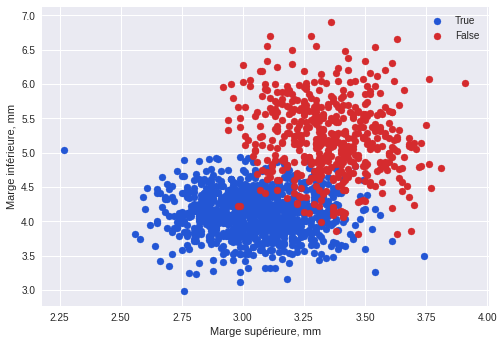

In [11]:
#on répresente les variables du modèle sur un graphique 
plt.style.use('seaborn') 
plt.scatter(x=billets_compl[billets_compl['is_genuine']]['margin_up'], y=billets_compl[billets_compl['is_genuine']]['margin_low'], c='#2356d5', label='True')
plt.scatter(x=billets_compl[~billets_compl['is_genuine']]['margin_up'], y=billets_compl[~billets_compl['is_genuine']]['margin_low'], c='#d52b2e', label='False')
plt.xlabel('Marge supérieure, mm')
plt.ylabel('Marge inférieure, mm')
plt.legend()
plt.savefig('anova.png', transparent=True)
plt.show()

Il est difficile de voir une corrélation linéaire entre marge_low et marge_up. Pourtant, la distinction entre les billets faux et les billets génuines est assez claire. 

On va tester si la marge entre le bord inférieur du billet et l'image de celui-ci dépend de la nature du billet à l'aide de l'ANOVA.

### **4. ANOVA**<a class="anchor" id="section_2_4"></a>

In [12]:
anova_gen = smf.ols('margin_low~is_genuine', data=billets_compl).fit()
print(anova_gen.summary())
sm.stats.anova_lm(anova_gen, typ=2)

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     2316.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          1.36e-303
Time:                        11:43:10   Log-Likelihood:                -781.24
No. Observations:                1463   AIC:                             1566.
Df Residuals:                    1461   BIC:                             1577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.2159      0

sum_sq      df            F         PR(>F)
is_genuine  395.000430     1.0  2315.553532  1.362034e-303
Residual    249.225777  1461.0          NaN            NaN

On est intéressé par le test de Fisher. La p-valeur de ce test ($1.36∗10^{-303}$) est très petite et largement inférieure à 5 %. On rejette l'hypothèse H0 selon laquelle α1=α2=0.

La nature du billet a donc bien un effet sur la marge entre le bord inférieur du billet et l'image de celui-ci.

### **5. Analyses sur les valeurs atypiques et/ou influentes**<a class="anchor" id="section_2_5"></a>

In [13]:
alpha = 0.05
n = billets_compl.shape[0]
p = 3

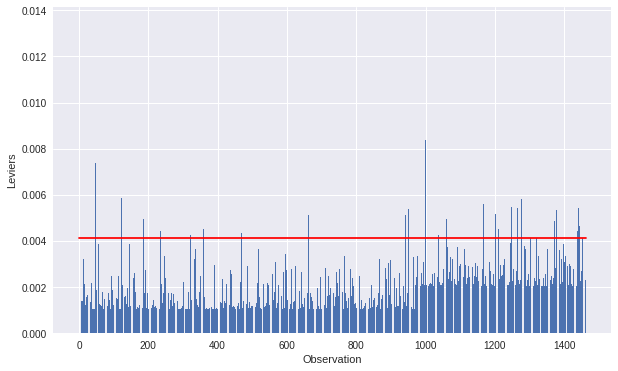

In [14]:
#on calcule les leviers
analyses = pd.DataFrame(reg.get_influence().hat_matrix_diag, columns=['levier'])
#on calcule la valeur de seuil
seuil_levier = 2*p/n
#on crée un graphique pour voir les points pour lesquels le levier est supérieur au seuil 
plt.figure(figsize=(10,6))
plt.bar(analyses.index, analyses['levier'])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_levier, seuil_levier], color='r')
plt.savefig('leviers.png', transparent=True)
plt.show()

In [15]:
#on sélectionne les points pour lesquels le levier est supérieur au seuil
analyses[analyses['levier']>seuil_levier]

levier
4     0.004748
48    0.007353
52    0.010647
54    0.004408
123   0.005865
...        ...
1441  0.005428
1442  0.004406
1444  0.004648
1446  0.004796
1453  0.004136

[67 rows x 1 columns]

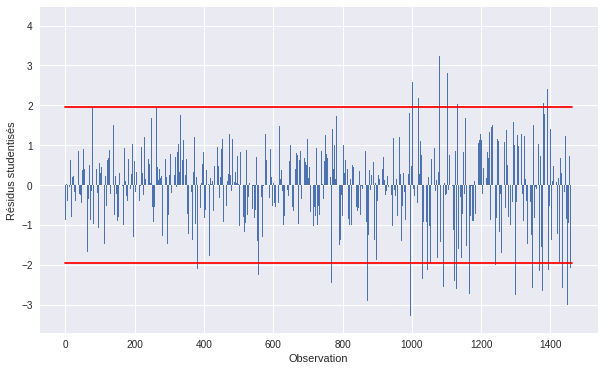

In [16]:
#on calcule les résidus studentisés
analyses['rstudent'] = reg.get_influence().resid_studentized_internal
#on calcule la valeur de seuil
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
#on crée un graphique pour voir les points pour lesquels les résidus studentisés sont supérieurs à la limite supérieure ou sont inférieurs à la limite inférieure
plt.figure(figsize=(10,6))
plt.bar(analyses.index, analyses['rstudent'])
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.savefig('rstudent.png', transparent=True)
plt.show()

In [17]:
#on sélectionne les points pour lesquels les résidus studentisés sont supérieurs à la limite supérieure ou sont inférieurs à la limite inférieure
analyses[abs(analyses['rstudent'])>seuil_rstudent]

levier  rstudent
10    0.001360 -2.260280
263   0.001906  1.965931
346   0.003559 -2.047795
382   0.001109 -2.114700
466   0.002227 -2.257411
...        ...       ...
1436  0.002500  2.536322
1441  0.005428  2.317452
1445  0.002168 -2.709317
1449  0.002053 -2.999746
1458  0.003424 -2.073333

[80 rows x 2 columns]

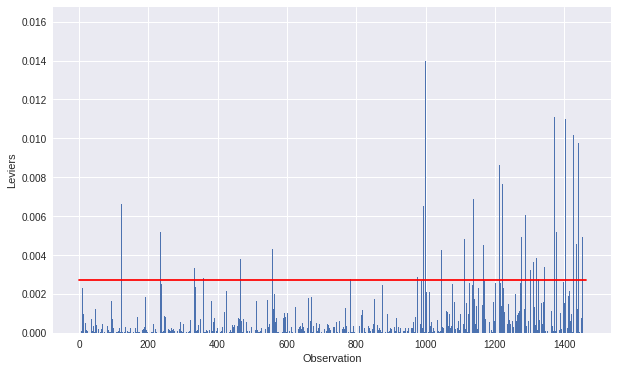

In [18]:
#on calcule la distance de Cook
influence = reg.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
#on calcule le seuil de la distance de Cook
seuil_dcook = 4/(n-p)
#on répresente les observations influantes à l'aide d'un graphique
plt.figure(figsize=(10,6))
plt.bar(analyses.index, analyses['dcooks'])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.savefig('dcook.png', transparent=True)
plt.show()

In [19]:
#on sélectionne les valeurs qui sont considérées comme atypiques et influentes en même temps, soit en utilisant les leviers, soit en utilisant les résidus studentisés
out_all = analyses[((analyses['levier']>seuil_levier)|(abs(analyses['rstudent'])>seuil_rstudent))&(analyses['dcooks']>seuil_dcook)]

In [20]:
#on supprime les valeurs atypiques et influentes du modèle
billets_compl_without_out = billets_compl.drop(out_all.index)
billets_compl_without_out

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1457       False    171.57       104.14        104.14        5.41       3.23   
1459       False    172.19       104.63        104.44        5.27       3.37   
1460       False    171.80       104.01        104.12        5.51       3.36   
1461       False    172.06       104.28        104.06        5.17       3.46   
1462       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1457  111.76  
1459  110.97  
1460  111.95  
1461  112.25  
1462  112.07  

[1377 rows x 7 columns]

In [21]:
#on crèe un autre modèle sans les valeurs atypiques et influentes détectées
reg_without_out = smf.ols('margin_low~is_genuine+margin_up', data=billets_compl_without_out).fit()
print(reg_without_out.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1508.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:43:15   Log-Likelihood:                -464.01
No. Observations:                1377   AIC:                             934.0
Df Residuals:                    1374   BIC:                             949.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9220      0

Comme on l'a prevu, le $R^{2}$ a augmenté un peu et il vaut maintenant 0.687. AIC et BIC ont diminué, ce qui signifie que la qualité du modèle s'est améliorée.

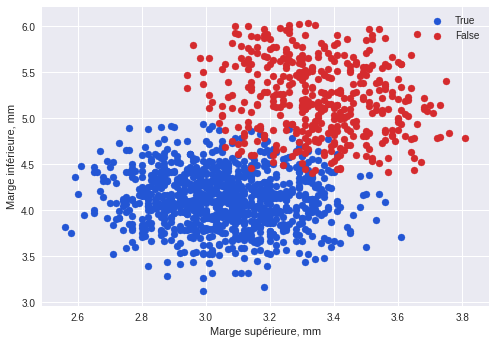

In [22]:
#on répresente les observation n'étant considerées comme atypiques et influentes 
plt.style.use('seaborn') 
plt.scatter(x=billets_compl_without_out[billets_compl_without_out['is_genuine']]['margin_up'], y=billets_compl_without_out[billets_compl_without_out['is_genuine']]['margin_low'], c='#2356d5', label='True')
plt.scatter(x=billets_compl_without_out[~billets_compl_without_out['is_genuine']]['margin_up'], y=billets_compl_without_out[~billets_compl_without_out['is_genuine']]['margin_low'], c='#d52b2e', label='False')
plt.xlabel('Marge supérieure, mm')
plt.ylabel('Marge inférieure, mm')
plt.legend()
plt.savefig('anova_after.png', transparent=True)
plt.show()

Les points du graphique sont plus centrés maintenant.

### **6. Détection des problèmes de colinéarité**<a class="anchor" id="section_2_6"></a>

In [23]:
#on vérifie l'éventuelle colinéarité approchée des variables à l'aide du VIF
variables = reg_without_out.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.601194775479072, 1.6011947754790719]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

### **7. Analyse de l'homoscédasticité des résidus**<a class="anchor" id="section_2_7"></a>

In [24]:
#on teste l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus avec le test de Breusch–Pagan 
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_without_out.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 8.423260192752714e-13


La p-valeur ici est inférieure à 5%, on rejette l'hypothèse H0 selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

In [25]:
#on va reconstruire le modèle en prenant en compte l'hétéroscédasticité des résidus (on utilise les erreurs-types robustes)
reg_without_out_hom = smf.ols('margin_low~is_genuine+margin_up', data=billets_compl_without_out).fit(cov_type='HC1')
print(reg_without_out_hom.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1232.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          3.34e-307
Time:                        11:43:15   Log-Likelihood:                -464.01
No. Observations:                1377   AIC:                             934.0
Df Residuals:                    1374   BIC:                             949.7
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9220      0

### **8. Test de la normalité des résidus**<a class="anchor" id="section_2_8"></a>

In [26]:
#on fait un test de Shapiro-Wilk pour tester la normalité des résidus
shapiro(reg_without_out.resid)

(0.996590793132782, 0.004007793962955475)

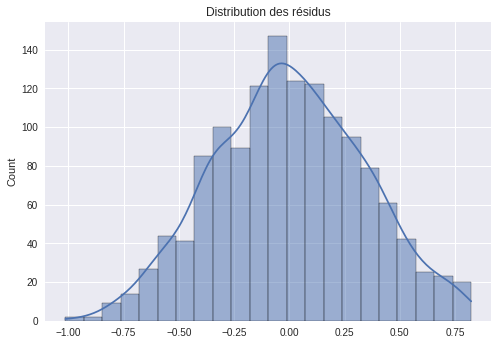

In [27]:
#distribution des résidus
sns.histplot(reg_without_out_hom.resid, kde=True)
plt.title('Distribution des résidus')
plt.savefig('residus.png', transparent=True)
plt.show()

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.004 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

### **9. Imputation des données manquantes**<a class="anchor" id="section_2_9"></a>

In [28]:
#on sélectionne les billets avec des données manquantes
billets_na = billets[billets['margin_low'].isna()].copy()
#on utilise notre modèle pour trouver les valeurs manquantes
billets_na['margin_low'] = reg_without_out_hom.predict(billets_na[['is_genuine', 'margin_up']])

In [29]:
#on crée une nouvelle liste et on impute les valeurs trouvées
billets_new = billets.copy()
billets_new.loc[billets_na.index.tolist(), 'margin_low'] = billets_na['margin_low']

## **Mission 2. Construction du modèle** <a class="anchor" id="chapter3"></a>

### **1. Exploration des données**<a class="anchor" id="section_3_1"></a>

**Nombre de lignes et de colonnes :** 1 500 lignes et 7 colonnes
<br>
**Type de variables :** booléen (is_genuine), quantitatives (diagonal, height_left, height_right, margin_low, margin_up, length)
<br>
&emsp;&emsp;Variable is_genuine : la nature du billet, vrais/faux ; dans le jeu de données on a 1000 vrais billets et 500 faux billets  <br>
&emsp;&emsp;Variable diagonale : la diagonale du billet (en mm) ; 171.04-173.01 mm <br>
&emsp;&emsp;Variable height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ; 103.14-104.88 mm<br>
&emsp;&emsp;Variable height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ; 102.82-104.95 mm<br>
&emsp;&emsp;Variable margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ; 2.98-6.9 mm<br>
&emsp;&emsp;Variable margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ; 2.27-3.91 mm<br>
&emsp;&emsp;Variable length : la longueur du billet (en mm) ; 109.49-114.44 mm<br>
**Analyse des valeurs manquantes :** aucune

In [30]:
billets_new

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [31]:
billets_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [32]:
billets_new.describe(include='all')

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1500.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.482922   
std           NaN     0.305195     0.299462      0.325627     0.659769   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.027500   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

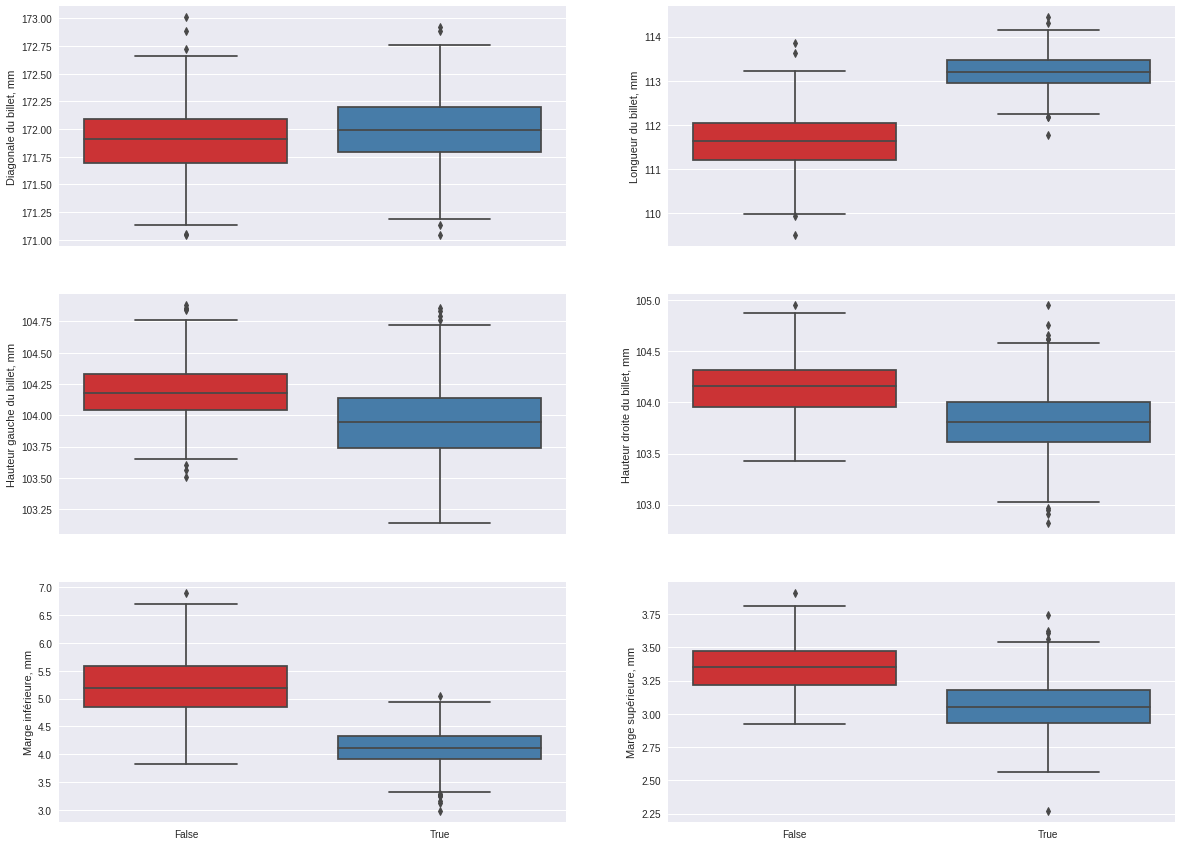

In [33]:
fig, axes = plt.subplots(3,2, figsize=(20,15), sharey=False, sharex=False)

sns.boxplot(ax=axes[0,0], x='is_genuine', y='diagonal', data=billets_new, palette='Set1')
axes[0,0].axes.xaxis.set_visible(False)
axes[0,0].set_ylabel('Diagonale du billet, mm')

sns.boxplot(ax=axes[0,1], x='is_genuine', y='length', data=billets_new, palette='Set1')
axes[0,1].axes.xaxis.set_visible(False)
axes[0,1].set_ylabel('Longueur du billet, mm')

sns.boxplot(ax=axes[1,0], x='is_genuine', y='height_left', data=billets_new, palette='Set1')
axes[1,0].axes.xaxis.set_visible(False)
axes[1,0].set_ylabel('Hauteur gauche du billet, mm')

sns.boxplot(ax=axes[1,1], x='is_genuine', y='height_right', data=billets_new, palette='Set1')
axes[1,1].axes.xaxis.set_visible(False)
axes[1,1].set_ylabel('Hauteur droite du billet, mm')

sns.boxplot(ax=axes[2,0], x='is_genuine', y='margin_low', data=billets_new, palette='Set1')
axes[2,0].set_xlabel('')
axes[2,0].set_ylabel('Marge inférieure, mm')

sns.boxplot(ax=axes[2,1], x='is_genuine', y='margin_up', data=billets_new, palette='Set1')
axes[2,1].set_xlabel('')
axes[2,1].set_ylabel('Marge supérieure, mm')

plt.show()

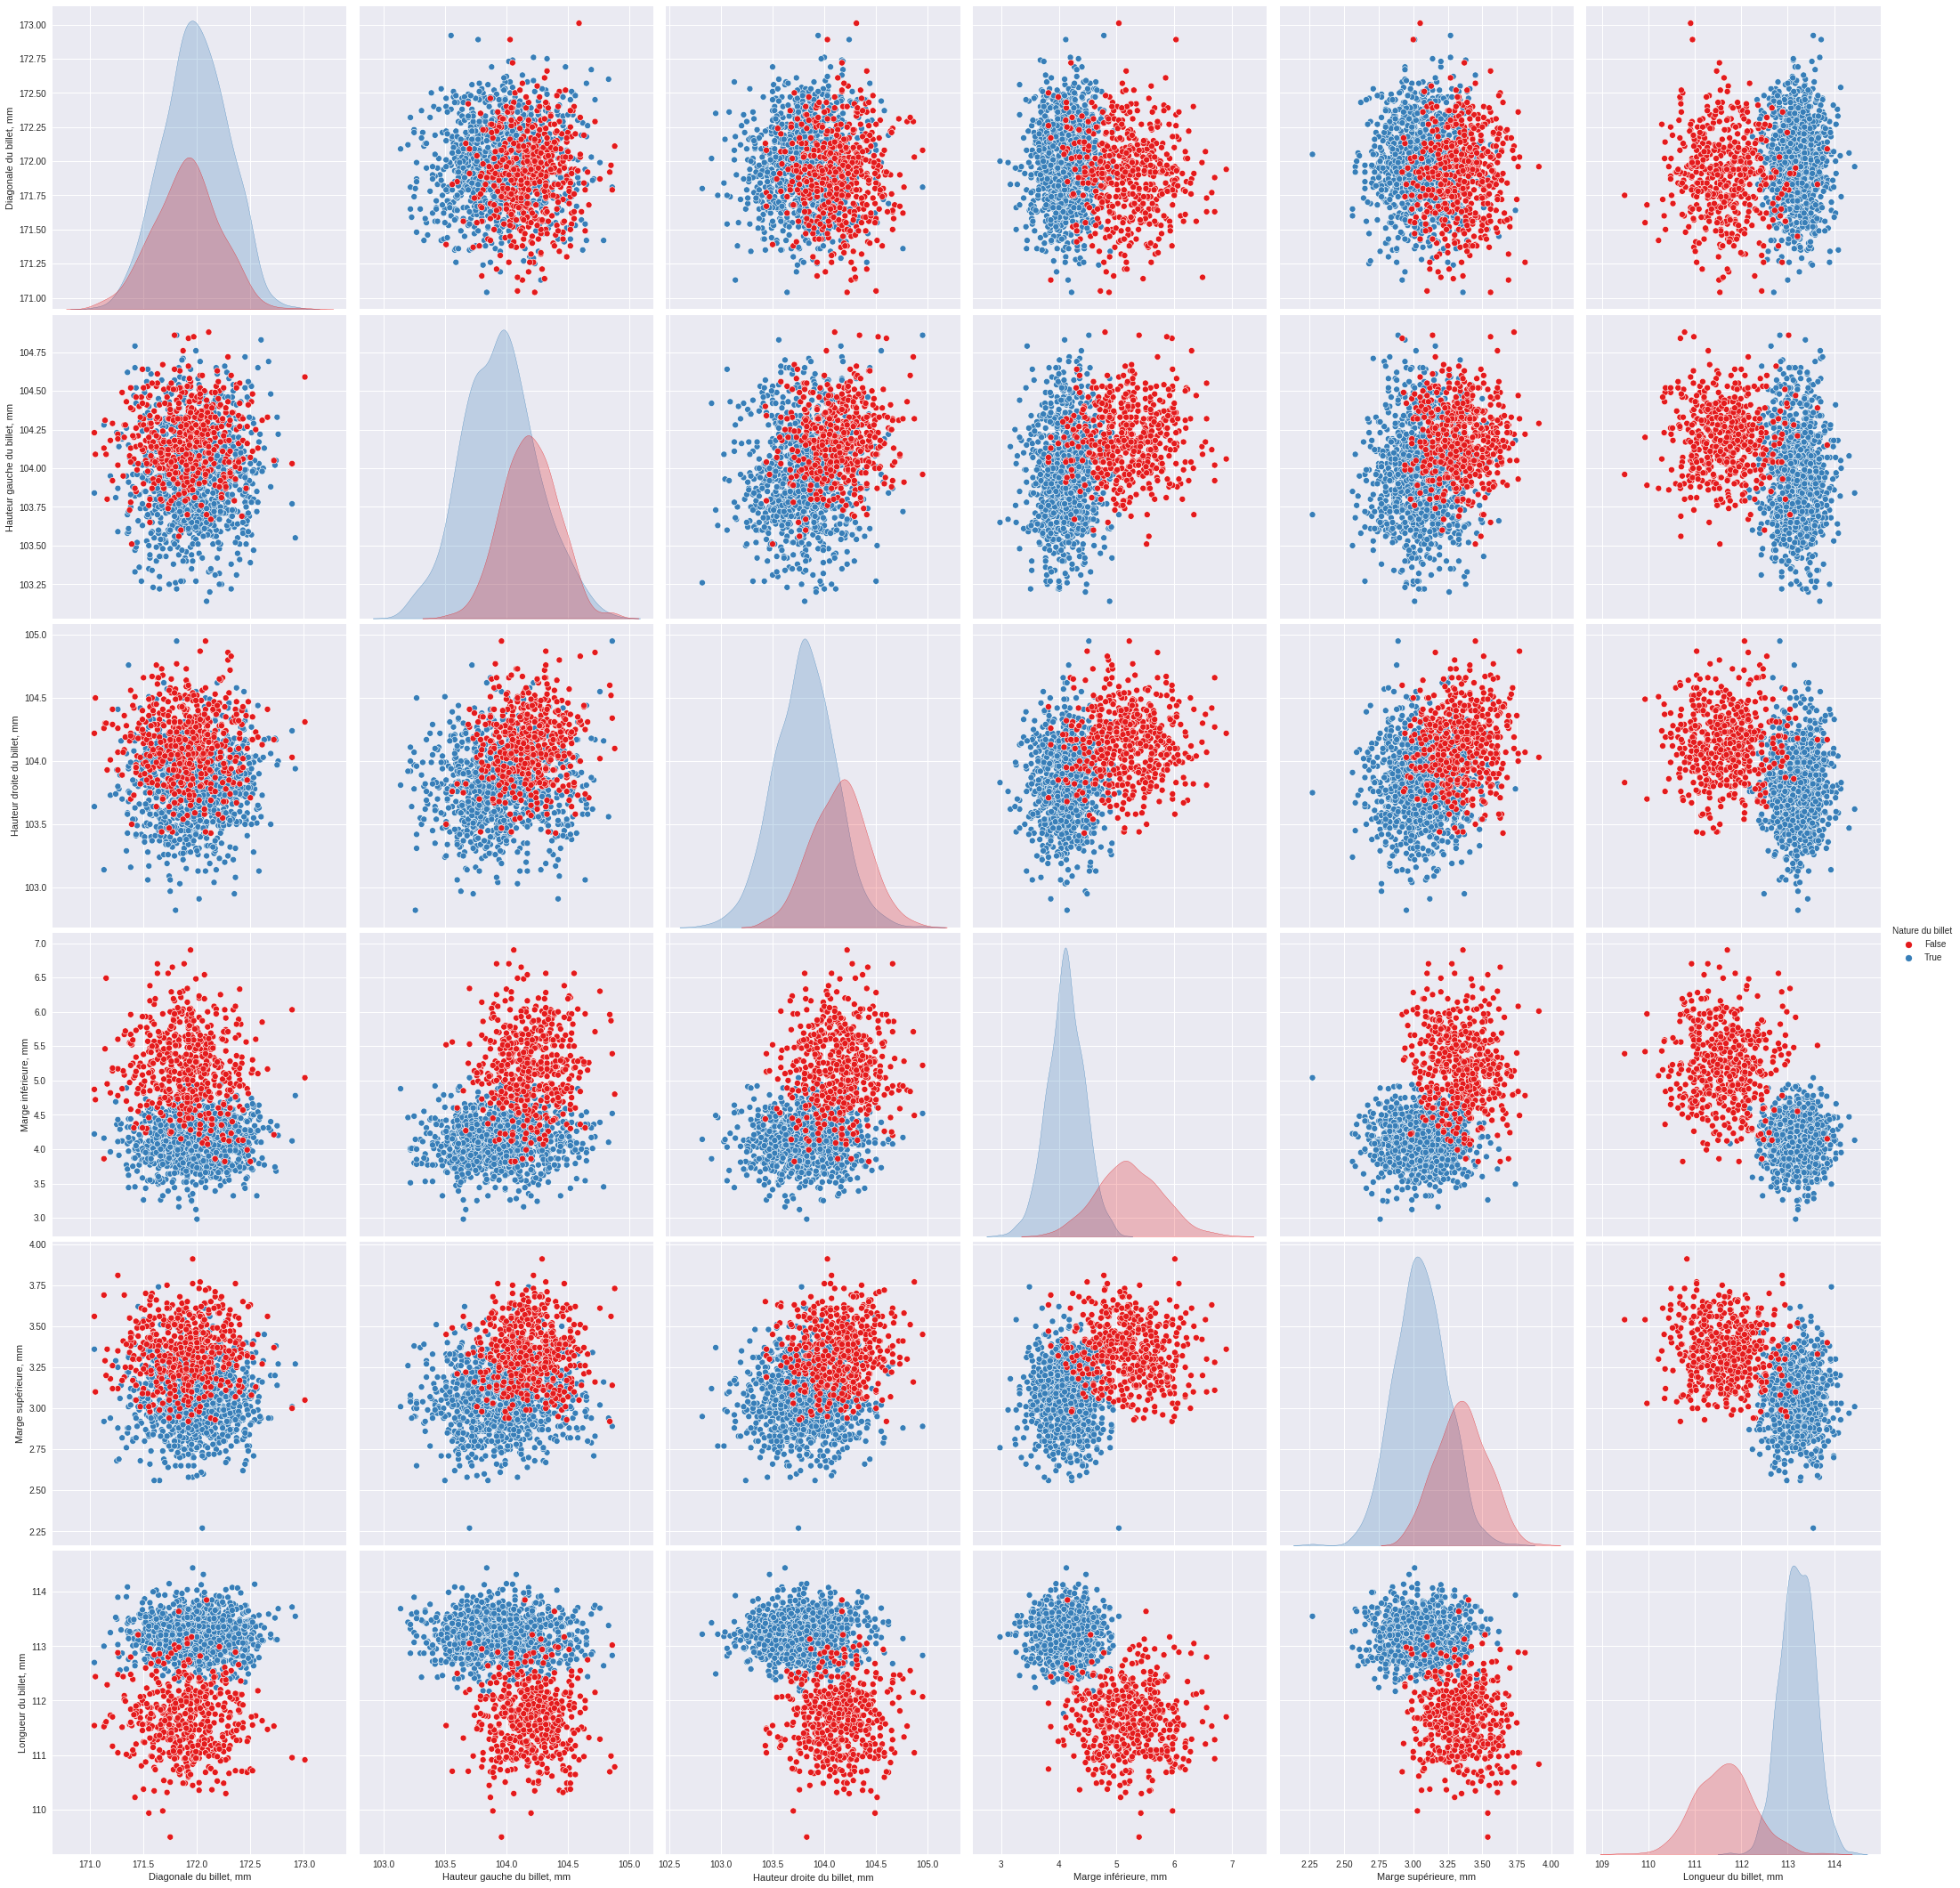

In [34]:
g = sns.pairplot(billets_new, hue='is_genuine', palette='Set1', diag_kind='kde', height=5)

replacements = {'diagonal': 'Diagonale du billet, mm', 
                'height_left': 'Hauteur gauche du billet, mm',
                'height_right': 'Hauteur droite du billet, mm', 
                'margin_low': 'Marge inférieure, mm',
                'margin_up': 'Marge supérieure, mm',
                'length': 'Longueur du billet, mm'}

for i in range(6):
    for j in range(6):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
g._legend.set_title('Nature du billet')
plt.savefig('pairplot.png', transparent=True)
plt.show()

Avec l'aide de ces graphiques on peut mettre en évidence les caractéristiques qui distinguent le plus les billets vrais des billets faux :  la longueur du billet, la marge entre le bord inférieur du billet et l'image de celui-ci. 

En même temps on voit que la variation de la diagonale des billets est légèrement différent pour les billets vrais et les billets faux.

### **Apprentissage non supervisé**<a class="anchor" id="section_3_2"></a>

### **2. K-means clustering**<a class="anchor" id="section_3_3"></a>

In [35]:
X = billets_new[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = billets_new['is_genuine']
#centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#clustering k-means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_scaled)

KMeans(n_clusters=2, random_state=0)

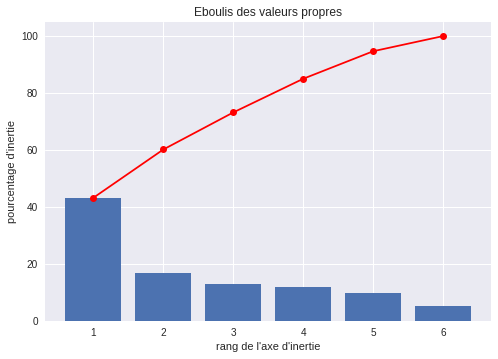

In [36]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=len(billets_new.columns)-1)
pca.fit(X_scaled)
# Eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [37]:
scree

array([43.20354927, 16.95722278, 13.02008425, 11.8251886 ,  9.66739787,
        5.32655723])

Notre échantillon n'a pas de structure visible, les variables n’ont presque pas de corrélation entre elles. La projection du nuage des individus sur le premier plan factoriel ne représente que 60 % de l’inertie totale. 

Pourtant, on est intéressé par une visualisation du nuage des individus et des centroïdes pour savoir quelles variables distinguent un vrai billet d'un faux billet le plus. Donc, on va projeter les données sur le premier plan factoriel.

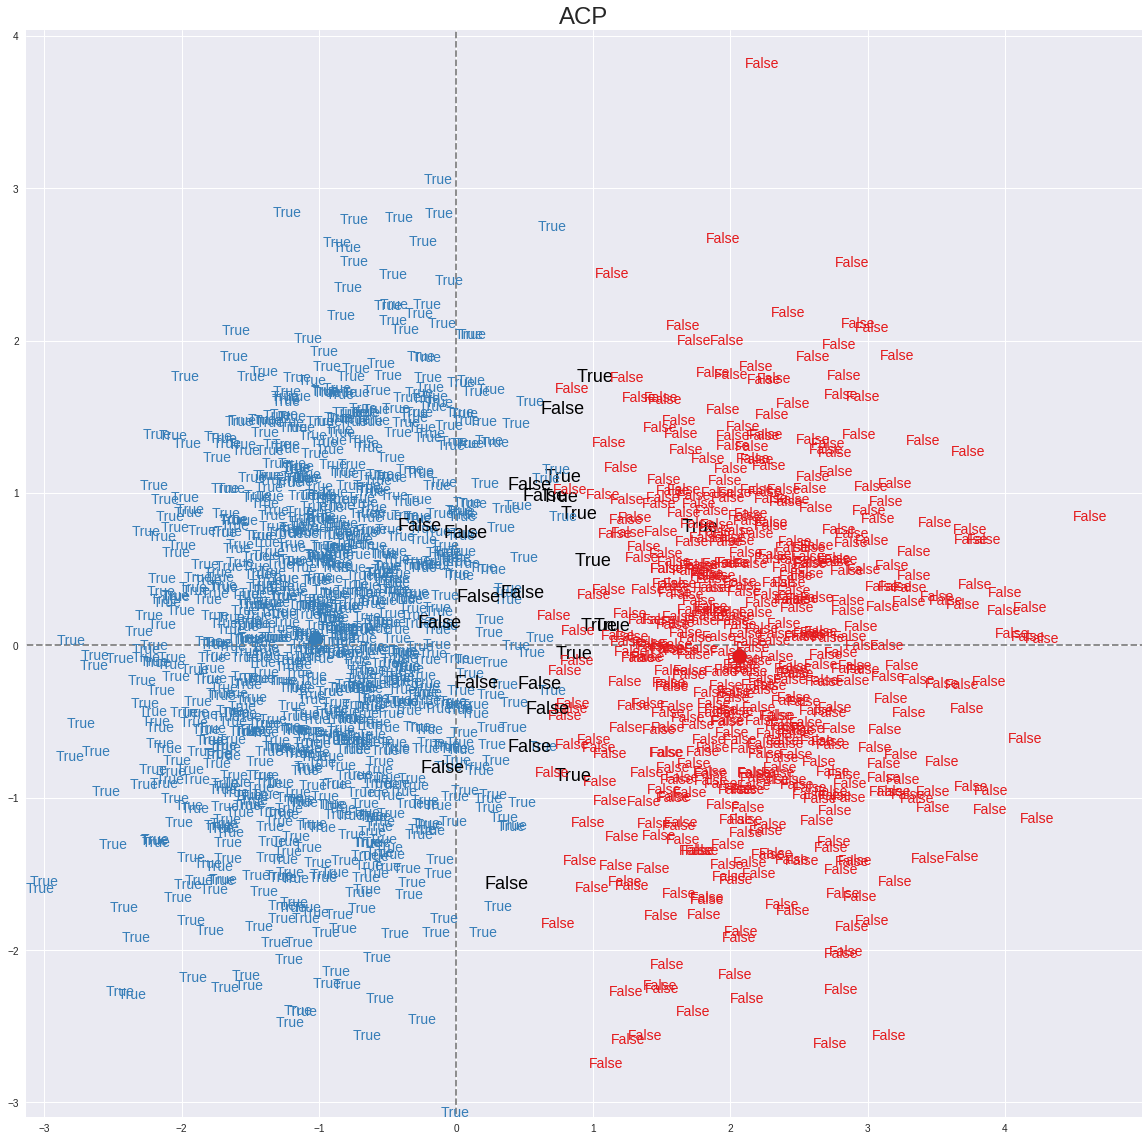

In [38]:
X_projected = pca.transform(X_scaled)
centroids = kmeans.cluster_centers_
centroids_projected = pca.transform(centroids)
fig = plt.figure(figsize=(20,20))

colors = np.array([(0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
                  (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)])

for i in range(X.shape[0]):
    if (kmeans.labels_[i] == 0 and y[i]) or (kmeans.labels_[i] == 1 and not y[i]):
    #si le billet a été bien détecté on le projete en rouge ou en blue (cela dépend du cluster)    
        plt.text(X_projected[i, 0], X_projected[i, 1], str(y[i]), color=colors[kmeans.labels_[i]], fontsize=14)
    else:
    #si le billet a été mal détecté on le projete en noir avec son nom réel 
        plt.text(X_projected[i, 0], X_projected[i, 1], str(y[i]), color='black', fontsize=18)
plt.xlim([np.min(X_projected[:, 0]), np.max(X_projected[:, 0])+0.5])
plt.ylim([np.min(X_projected[:, 1]), np.max(X_projected[:, 1])+0.25])
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')
#centroïdes
plt.scatter(centroids_projected[:,0] , centroids_projected[:,1] , s=200, c=colors, cmap='Set1', marker='o', edgecolors='black')
plt.title('ACP', fontsize=24)
plt.savefig('ACP_billets.png', transparent=True)
plt.show()

Les clusters sont assez bien distingués. Ils se croisent un peu et cela conduit à des erreurs pour déterminer à quel groupe appartient un billet. 24 billets ont été mal-détectés avec la méthode des k-means.

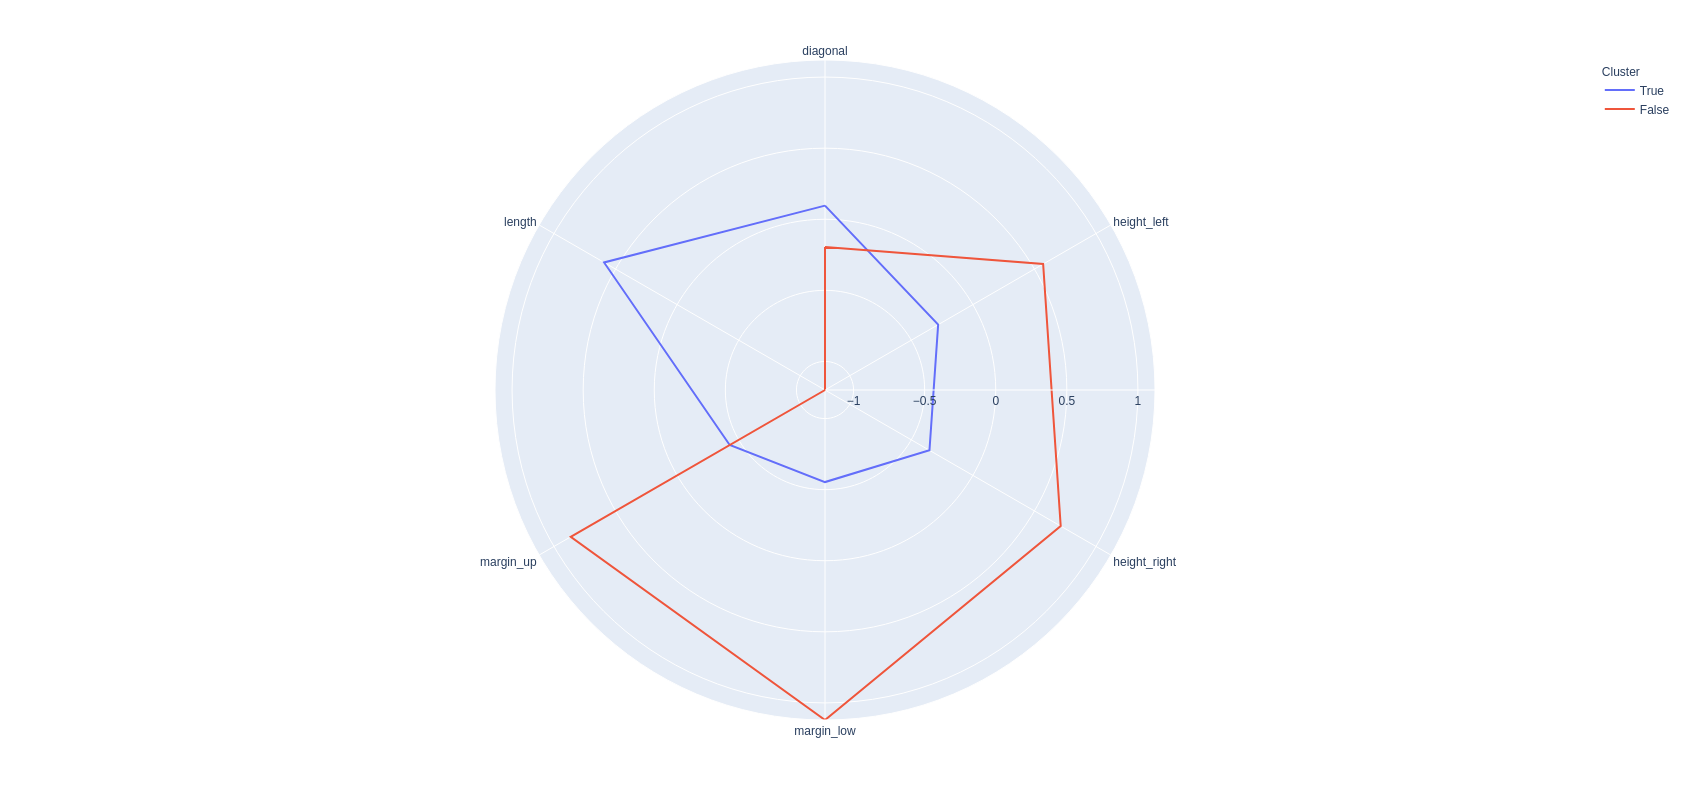

In [39]:
# un graphiqie pour voir comment les clusters ont été déterminés
#on crée un dataframe avec X_scaled et y
clusters = pd.DataFrame(X_scaled, index=y, columns=billets_new.drop(columns='is_genuine').columns)
#on ajoute une colonne avec les numéros des clusters accordés
clusters['Cluster'] = kmeans.labels_.astype(bool)
#k-means a mis les vrais billets dans le cluster 0, ce qui correspond à 'False', donc va inverser les valeurs de cette colonne
clusters['Cluster'] = ~clusters['Cluster']
polar = clusters.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar, id_vars=["Cluster"])
fig = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True, height=800, width=1400, category_orders={"Cluster": [True, False]})
fig.show()

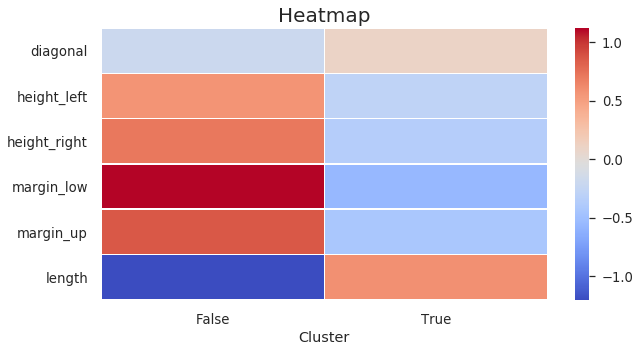

In [40]:
#heatmap
heatmap_df = clusters.groupby("Cluster").mean().transpose()
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Heatmap', fontsize=20)
ax = sns.heatmap(heatmap_df, linewidths=.5, cmap='coolwarm')
#plt.savefig('heatmap_billets.png', transparent=True, bbox_inches='tight')

Les vrais billets sont caractérisés surtout par une longueur plus grande, ainsi que par la taille de diagonale plus grande.<br>
Les faux billets sont les billets ayant une hauteur et une marge relativement grandes.

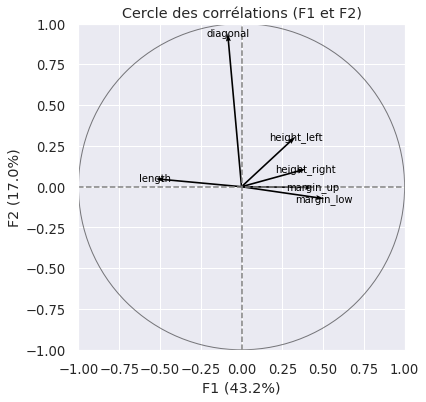

In [41]:
pcs = pca.components_
display_circles(pcs, 2, pca, [(0,1),(2,3), (4,5)], labels=np.array(X.columns))

La variable synthétique F1 envoie les vrais billets, comme les billets les plus longs, à gauche et les faux billets, ayant la hauteur et la marge plus grandes, à droit. Cette variable nous répond à la question "Ce billet est-il et vrai ou faux ?"<br>
La variable synthétique F2 est presque à cent pour cent représentée par la diagonale du billet. 

1. La précision du classifieur k-means : 98.40%
2. Billets mal identifiés :


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95    4.520000       2.89   
253         True    172.07       104.33        104.33    4.410000       3.39   
341         True    171.90       104.21        104.21    4.770000       3.38   
580         True    171.76       104.48        104.01    4.350000       3.37   
626         True    171.98       104.44        104.08    4.670000       3.21   
669         True    172.14       104.34        104.20    4.630000       3.02   
724         True    172.16       104.43        104.06    4.510000       3.19   
728         True    171.94       104.11        104.16    4.080000       3.35   
743         True    172.30       104.58        104.17    4.360000       3.33   
946         True    171.63       103.87        104.66    4.074471       3.27   
1025       False    172.17       104.20        104.13    3.860000       3.38   
1073       False    172.13       103.67        103.82    4.270000       3.22   
1081       False    171.82       103.90        103.67    4.790000       3.36   
1083       False    171.85       103.60        103.82    4.600000       3.21   
1103       False    171.88       104.05        103.75    4.410000       3.21   
1104       False    171.95       103.89        103.69    4.450000       3.42   
1122       False    172.09       104.15        104.17    4.150000       3.40   
1160       False    172.39       104.05        104.32    4.130000       3.41   
1267       False    172.13       103.99        103.78    5.470000       2.94   
1362       False    171.56       103.80        103.87    5.660000       2.98   
1383       False    171.75       104.16        104.16    4.230000       2.99   
1407       False    172.02       103.99        104.28    4.220000       2.98   
1412       False    172.25       103.94        103.68    4.140000       3.25   
1482       False    172.30       104.04        103.85    4.120000       3.27   

      length  
0     112.83  
253   113.39  
341   113.20  
580   113.09  
626   112.73  
669   112.47  
724   112.69  
728   111.76  
743   112.98  
946   112.68  
1025  112.44  
1073  112.15  
1081  112.43  
1083  112.50  
1103  112.52  
1104  112.02  
1122  113.85  
1160  112.66  
1267  112.30  
1362  112.95  
1383  111.83  
1407  112.42  
1412  112.48  
1482  111.69

3. Matrice de confusion, k-NN :


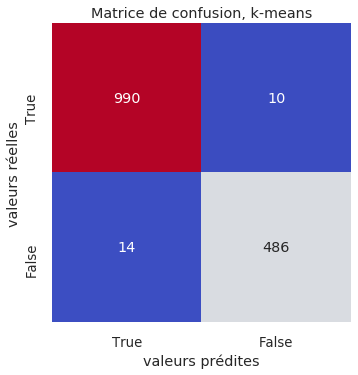

4. Rapport de classification, k-means :
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       500
        True       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [42]:
#évaluation du modèle
vp_k=clusters[(clusters.index == clusters['Cluster']) & (clusters['Cluster'])]['Cluster'].count()
vf_k=clusters[(clusters.index == clusters['Cluster']) & (~clusters['Cluster'])]['Cluster'].count()
fn_k=clusters[(clusters.index != clusters['Cluster']) & (~clusters['Cluster'])]['Cluster'].count()
fp_k=clusters[(clusters.index != clusters['Cluster']) & (clusters['Cluster'])]['Cluster'].count()
total=vp_k+vf_k+fn_k+fp_k
corrects=vp_k+vf_k
      
score_k=corrects/total
accuracy_k = "{:.2%}".format(round(score_k,4))
print(f'1. La précision du classifieur k-means : {accuracy_k}')

print('2. Billets mal identifiés :')
display(billets_new[clusters.index != clusters['Cluster']])

print('3. Matrice de confusion, k-NN :')
conf_k = [[vp_k, fn_k], [fp_k, vf_k]]
sns.heatmap(conf_k, square=True, annot=True, cbar=False, xticklabels=list(y.unique()), yticklabels=list(y.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion, k-means')
plt.savefig('heatmap_k_billets.png', transparent=True)
plt.show()

print('4. Rapport de classification, k-means :')
print(metrics.classification_report(y, clusters['Cluster']))

### **Apprentissage supervisé**<a class="anchor" id="section_3_4"></a>

### **3. K-NN**<a class="anchor" id="section_3_5"></a>

In [43]:
data = billets_new[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
target = billets_new['is_genuine']

In [44]:
#on sépare le jeu de données en training set et testing set
xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)

In [45]:
#on crée deux dataframes : pour le training set
df_train = xtrain.copy()
df_train['is_genuine'] = ytrain
#et pour le testing set
df_test = xtest.copy()
df_test['is_genuine'] = ytest

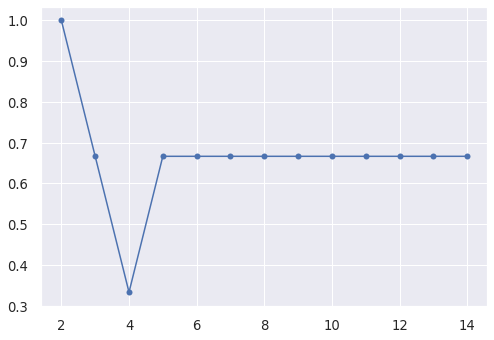

In [46]:
#on cherche le k optimal
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

Le k-NN le plus performant est celui pour lequel k = 5. On connaît donc notre classifieur final optimal : 4-nn.

In [79]:
#modélisation 
knn = neighbors.KNeighborsClassifier(4)
knn.fit(xtrain, ytrain)
#prédiction
ypred_knn = knn.predict(xtest)
df_test_knn = df_test.copy()
df_test_knn['predicted'] = ypred_knn

1. La précision du classifieur knn : 99.67%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
1025    172.17        104.2        104.13        3.86       3.38  112.44   

      is_genuine  predicted  
1025       False       True

3. Matrice de confusion, k-NN :


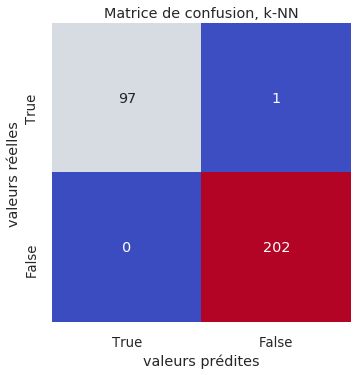

4. Rapport de classification, régression logistique :
              precision    recall  f1-score   support

       False       1.00      0.99      0.99        98
        True       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300

5. Cross-validation résultats :
[0.98666667 0.98666667 0.99666667 0.99333333 0.98666667]


In [80]:
#évaluation du modèle
accuracy_knn = "{:.2%}".format(round(knn.score(xtest, ytest),4))
print(f'1. La précision du classifieur knn : {accuracy_knn}')

print('2. Billets mal identifiés :')
display(df_test_knn[df_test_knn['is_genuine'] != df_test_knn['predicted']])

print('3. Matrice de confusion, k-NN :')
conf_knn = metrics.confusion_matrix(df_test_knn['is_genuine'], df_test_knn['predicted'])
sns.heatmap(conf_knn, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion, k-NN')
plt.show()

print('4. Rapport de classification, régression logistique :')
print(metrics.classification_report(df_test_knn['is_genuine'], df_test_knn['predicted']))

print('5. Cross-validation résultats :')
scores_knn = cross_val_score(knn, data, target, cv=5)
score_knn = np.mean(scores_knn)
print(scores_knn)

### **4. Régression logistique**<a class="anchor" id="section_3_6"></a>

Il existe trois façons de construire une régression logistique : 2 avec la Statsmodels librairie et 1 avec Scikit-learn librairie.<br>
Il y a des différences entre ces trois méthodes qu l'on doit prendre en compte lors de la construction des modèles (régularisation, penalty, constante...). <br>
On utilise Statsmodels pour une inférence statistique. <br>
On utilise Scikit-learn pour des prédictions précises.<br>
C'est donc le modèle avec Scikit-learn qui nous intéresse le plus. Pourtant, Statsmodels nous permettra d'analyser le modèle du point de vue statistique et d'analyser la significativité des variables.

### Régression logistique, statsmodels.formula.api.glm() 

In [49]:
#modélisation
reg_log_smf_init = smf.glm('is_genuine ~ diagonal+height_left+height_right+margin_low+margin_up+length', data=df_train, family=sm.families.Binomial()).fit()
print(reg_log_smf_init.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1193
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -35.251
Date:                                       Tue, 06 Jul 2021   Deviance:                       70.502
Time:                                               11:43:32   Pearson chi2:                 1.77e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons. On va donc retirer les variables non significatives.

In [50]:
#modélisation seulement avec les valeurs significatives
reg_log_smf_fin = smf.glm('is_genuine ~ height_right+margin_low+margin_up+length', data=df_train, family=sm.families.Binomial()).fit()
print(reg_log_smf_fin.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1195
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -36.038
Date:                                       Tue, 06 Jul 2021   Deviance:                       72.075
Time:                                               11:43:32   Pearson chi2:                 2.22e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

In [51]:
#prédiction
ypred_log_smf = reg_log_smf_fin.predict(xtest)
df_test_log_smf = df_test.copy()
df_test_log_smf['predicted_prob'] = ypred_log_smf
df_test_log_smf['predicted'] = True
df_test_log_smf.loc[df_test_log_smf['predicted_prob']>0.5, 'predicted'] = False

In [52]:
display(df_test_log_smf.sort_values('predicted').style.format({'predicted': "{:.2%}"}))

1. La précision de la régression logistique : 99.33%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
1025    172.17       104.20        104.13        3.86       3.38  112.44   
1073    172.13       103.67        103.82        4.27       3.22  112.15   

      is_genuine  predicted_prob  predicted  
1025       False        0.129477       True  
1073       False        0.443607       True

3. Matrice de confusion, régression logistique :


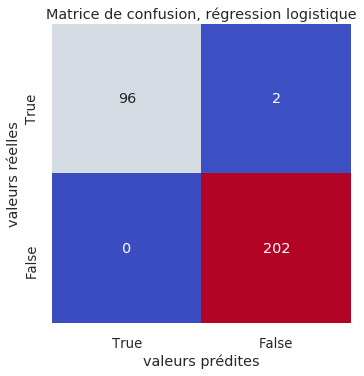

4. Rapport de classification, régression logistique :
              precision    recall  f1-score   support

       False       1.00      0.98      0.99        98
        True       0.99      1.00      1.00       202

    accuracy                           0.99       300
   macro avg       1.00      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [53]:
#évaluation du modèle
accuracy_log_smf = "{:.2%}".format(round(metrics.accuracy_score(df_test_log_smf['predicted'], ytest),4))
print(f'1. La précision de la régression logistique : {accuracy_log_smf}')

print('2. Billets mal identifiés :')
display(df_test_log_smf[df_test_log_smf['is_genuine'] != df_test_log_smf['predicted']])

print('3. Matrice de confusion, régression logistique :')
conf_log_smf = metrics.confusion_matrix(df_test_log_smf['is_genuine'], df_test_log_smf['predicted'])
sns.heatmap(conf_log_smf, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion, régression logistique')
plt.show()

print('4. Rapport de classification, régression logistique :')
print(metrics.classification_report(df_test_log_smf['is_genuine'], df_test_log_smf['predicted']))

### Régression logistique, statsmodels.api.Logit()

In [54]:
reg_log_sm_in = sm.Logit(ytrain, sm.add_constant(xtrain)).fit()
print(reg_log_sm_in.summary())

Optimization terminated successfully.
         Current function value: 0.029376
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Tue, 06 Jul 2021   Pseudo R-squ.:                  0.9539
Time:                        11:43:33   Log-Likelihood:                -35.251
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -236.8741    265.588     -0.892      0.372    -757.417     283.669
diagonal         0.587

In [55]:
#modélisation
reg_log_sm = sm.Logit(ytrain, sm.add_constant(xtrain[['height_right', 'margin_low', 'margin_up', 'length']])).fit()
print(reg_log_sm.summary())

Optimization terminated successfully.
         Current function value: 0.030031
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Tue, 06 Jul 2021   Pseudo R-squ.:                  0.9529
Time:                        11:43:33   Log-Likelihood:                -36.038
converged:                       True   LL-Null:                       -765.20
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -250.2442    145.130     -1.724      0.085    -534.693      34.205
height_right    -3.080

In [56]:
#prédiction
df_test_log_sm = df_test.copy()
xtest_with_constant = sm.add_constant(xtest[['height_right', 'margin_low', 'margin_up', 'length']])
ypred_log_sm = reg_log_sm.predict(xtest_with_constant)
df_test_log_sm['predicted_prob'] = ypred_log_sm
df_test_log_sm['predicted'] = True
df_test_log_sm.loc[df_test_log_sm['predicted_prob']<=0.5, 'predicted'] = False

1. La précision de la régression logistique : 99.33%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
1025    172.17       104.20        104.13        3.86       3.38  112.44   
1073    172.13       103.67        103.82        4.27       3.22  112.15   

      is_genuine  predicted_prob  predicted  
1025       False        0.870523       True  
1073       False        0.556393       True

3. Matrice de confusion, régression logistique :


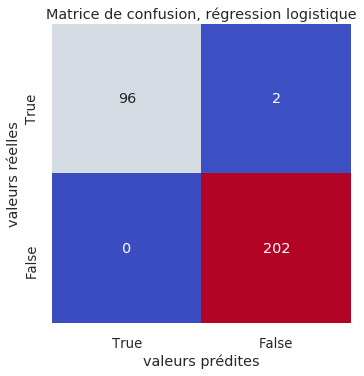

4. Rapport de classification, régression logistique :
              precision    recall  f1-score   support

       False       1.00      0.98      0.99        98
        True       0.99      1.00      1.00       202

    accuracy                           0.99       300
   macro avg       1.00      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [57]:
#évaluation du modèle
accuracy_log_sm = "{:.2%}".format(round(metrics.accuracy_score(df_test_log_sm['predicted'], ytest),4))
print(f'1. La précision de la régression logistique : {accuracy_log_sm}')

print('2. Billets mal identifiés :')
display(df_test_log_sm[df_test_log_sm['is_genuine'] != df_test_log_sm['predicted']])

print('3. Matrice de confusion, régression logistique :')
conf_log_sm = metrics.confusion_matrix(df_test_log_sm['is_genuine'], df_test_log_sm['predicted'])
sns.heatmap(conf_log_sm, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion, régression logistique')
plt.show()

print('4. Rapport de classification, régression logistique :')
print(metrics.classification_report(df_test_log_sm['is_genuine'], df_test_log_sm['predicted']))

### Régression logistique, sklearn.linear_model.LogisticRegression()

In [58]:
#modélisation
reg_log_sklearn = LogisticRegression(max_iter=200)
reg_log_sklearn.fit(xtrain, ytrain)
#prédiction
df_test_log_sklearn = df_test.copy()
ypred_log_sklearn = reg_log_sklearn.predict(xtest)
df_test_log_sklearn['predicted'] = ypred_log_sklearn 
print(reg_log_sklearn.intercept_)
print(reg_log_sklearn.coef_)

[-0.01841617]
[[-0.07512704 -1.52847836 -1.99668897 -3.56245952 -3.178166    3.612553  ]]


1. La précision de la régression logistique : 99.33%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
1025    172.17       104.20        104.13        3.86       3.38  112.44   
1073    172.13       103.67        103.82        4.27       3.22  112.15   

      is_genuine  predicted  
1025       False       True  
1073       False       True

3. Matrice de confusion, régression logistique :


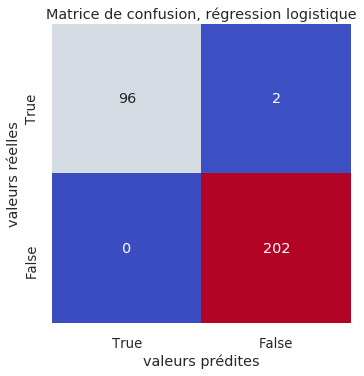

4. Rapport de classification, régression logistique :
              precision    recall  f1-score   support

       False       1.00      0.98      0.99        98
        True       0.99      1.00      1.00       202

    accuracy                           0.99       300
   macro avg       1.00      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

5. Cross-validation résultats :
[0.98666667 0.98666667 0.99666667 0.98666667 0.99333333]


In [59]:
#évaluation du modèle
accuracy_log_sklearn = "{:.2%}".format(round(metrics.accuracy_score(df_test_log_sklearn['predicted'], ytest),4))
print(f'1. La précision de la régression logistique : {accuracy_log_sklearn}')

print('2. Billets mal identifiés :')
display(df_test_log_sklearn[df_test_log_sklearn['is_genuine'] != df_test_log_sklearn['predicted']])

print('3. Matrice de confusion, régression logistique :')
conf_log_sklearn = metrics.confusion_matrix(df_test_log_sklearn['is_genuine'], df_test_log_sklearn['predicted'])
sns.heatmap(conf_log_sklearn, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title('Matrice de confusion, régression logistique')
plt.show()

print('4. Rapport de classification, régression logistique :')
print(metrics.classification_report(df_test_log_sklearn['is_genuine'], df_test_log_sklearn['predicted']))

print('5. Cross-validation résultats :')
scores_log = cross_val_score(reg_log_sklearn, data, target, cv=5)
score_log = np.mean(scores_log)
print(scores_log)

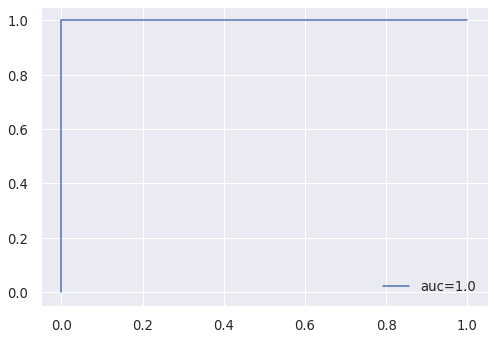

In [60]:
y_pred_proba = reg_log_sklearn.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

Le score AUC pour le cas est de 0,99. Le score AUC 1 représente un classificateur parfait. Donc notre classificateur est presque idéal.

### **5. Arbre de décisions**<a class="anchor" id="section_3_7"></a>

In [61]:
feature_columns = ['margin_low', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']

In [62]:
#modélisation
arbre = DecisionTreeClassifier()
arbre.fit(xtrain,ytrain)
#prédiction
ypred_arbre = arbre.predict(xtest)
df_test_arbre = df_test.copy()
df_test_arbre['predicted'] = ypred_arbre

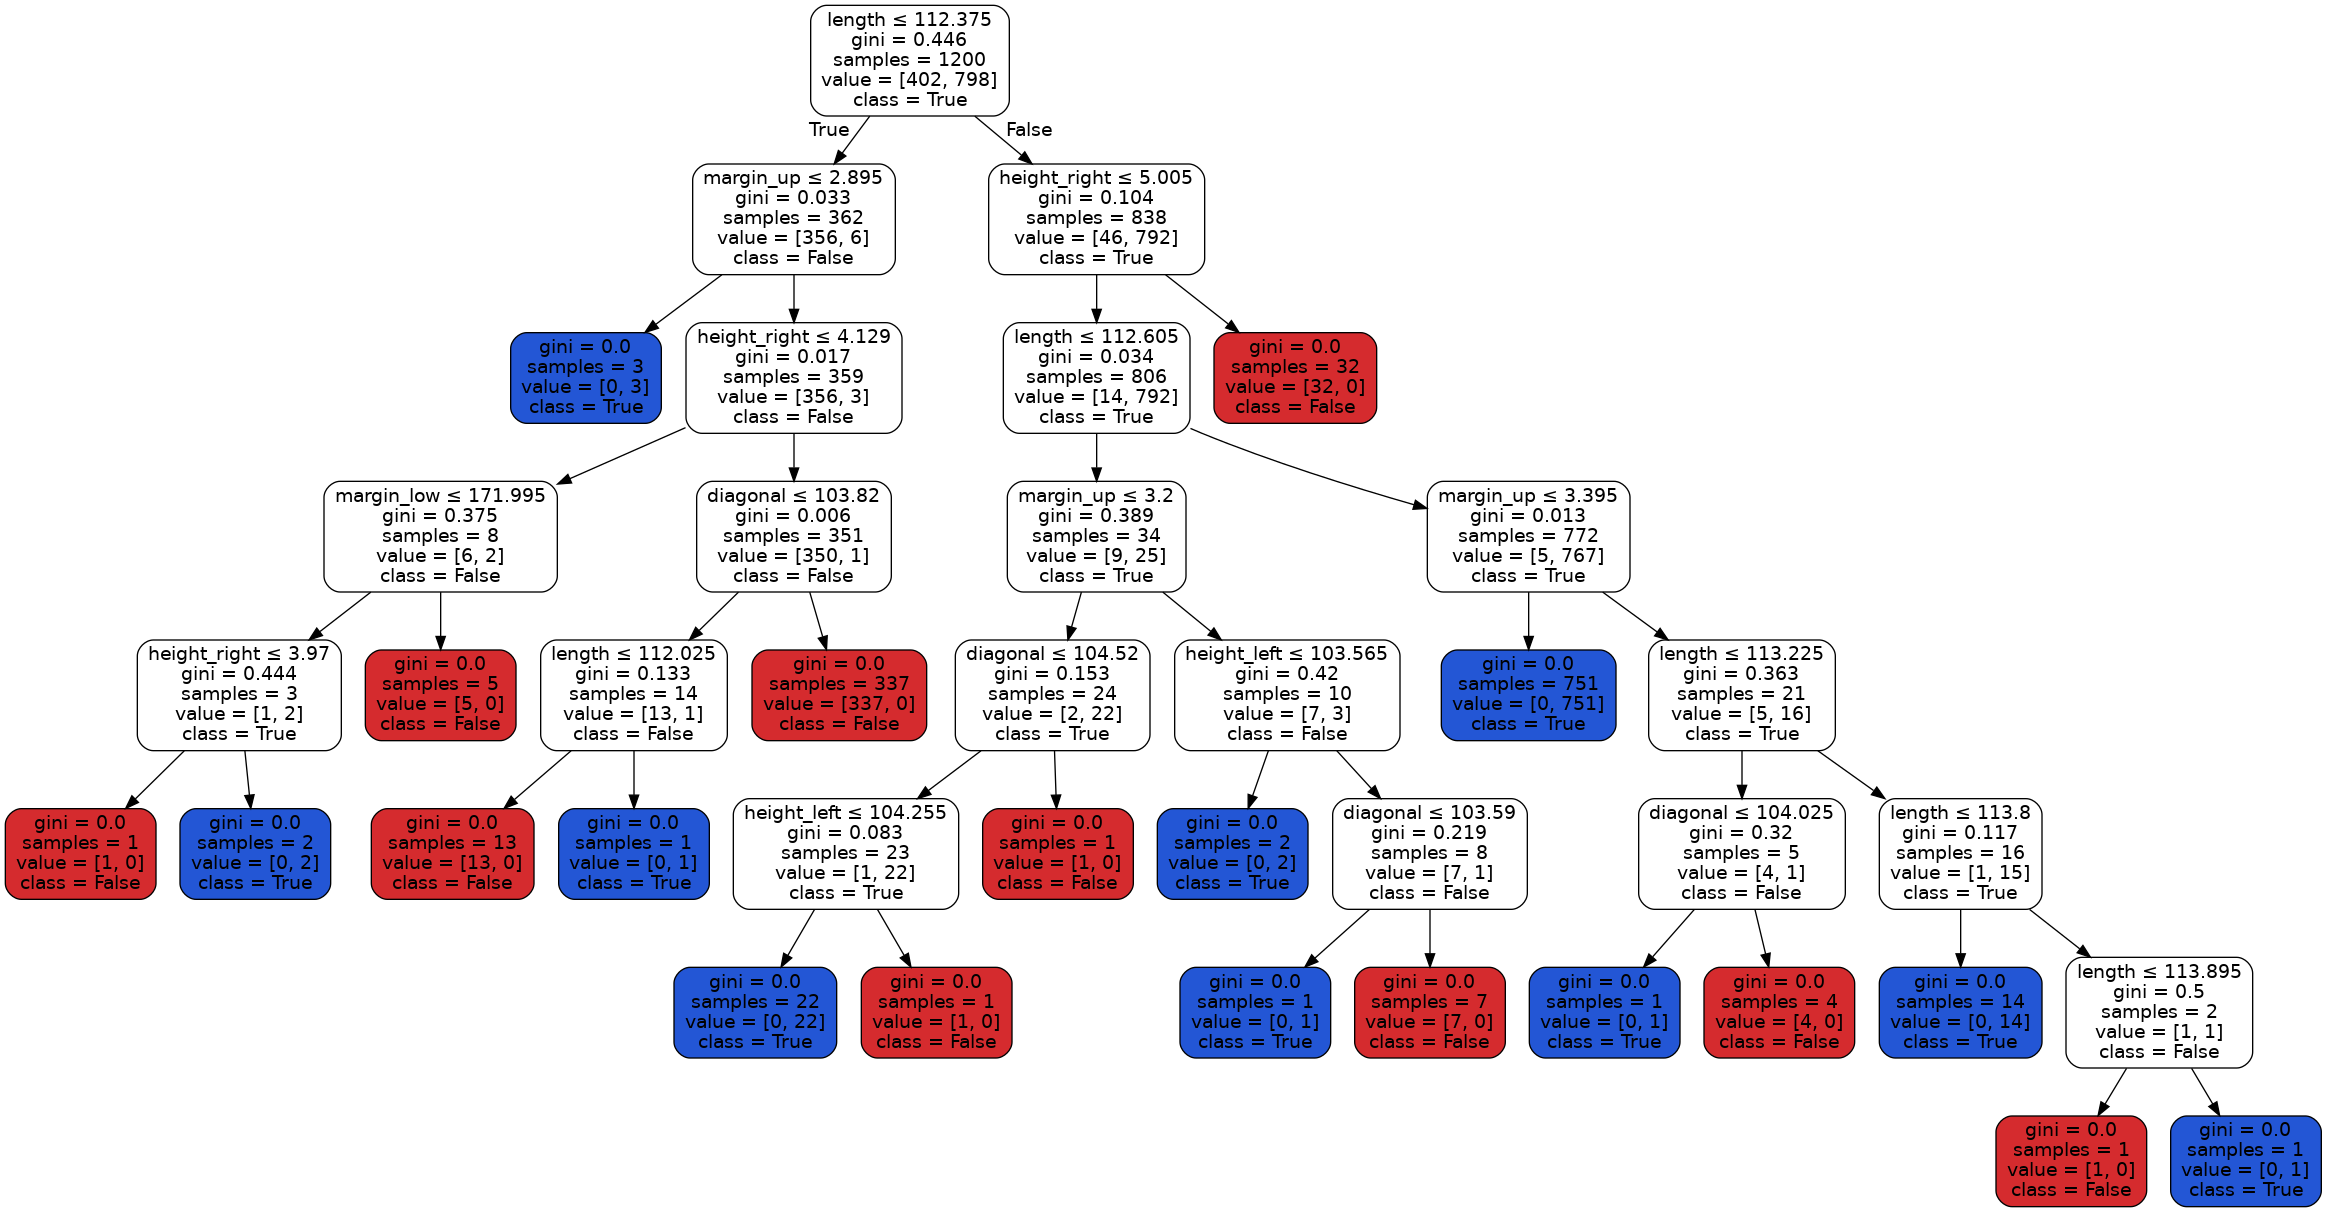

In [63]:
#visualisation de l'arbre de décision
dot_data = StringIO()
export_graphviz(arbre, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_columns, class_names=['False', 'True'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
nodes = graph.get_node_list()
colors =  ( '#d52b2e',  '#2356d5', 'white')
for node in nodes:
    if node.get_name() not in ('node', 'edge'):
        values = arbre.tree_.value[int(node.get_name())][0]
        #colorer uniquement les nœuds où une classe est identifié 
        if max(values) == sum(values):    
            node.set_fillcolor(colors[np.argmax(values)])
        #les nœuds mixtes obtiennent la couleur blanc
        else:
            node.set_fillcolor(colors[-1])

graph.write_png('billets.png')
Image(graph.create_png())

1. La précision de l'arbre de décisions : 96.33%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
1467    171.16       103.80        103.93        4.95       3.36  112.29   
855     172.26       104.66        103.58        4.36       2.80  112.44   
664     172.05       103.70        103.75        5.04       2.27  113.55   
1157    172.09       103.70        104.27        5.53       3.51  112.20   
1404    171.76       103.79        104.05        5.12       3.22  112.08   
737     172.16       104.39        103.85        3.77       3.32  112.55   
295     172.34       104.54        103.56        4.04       3.42  112.93   
985     171.88       103.87        104.02        4.12       3.33  112.47   
1073    172.13       103.67        103.82        4.27       3.22  112.15   
75      172.26       103.85        103.70        4.16       3.20  112.35   
48      172.07       104.05        103.82        3.71       3.61  113.05   

      is_genuine  predicted  
1467       False       True  
855         True      False  
664         True      False  
1157       False       True  
1404       False       True  
737         True      False  
295         True      False  
985         True      False  
1073       False       True  
75          True      False  
48          True      False

3. Matrice de confusion, l'arbre de décisions :


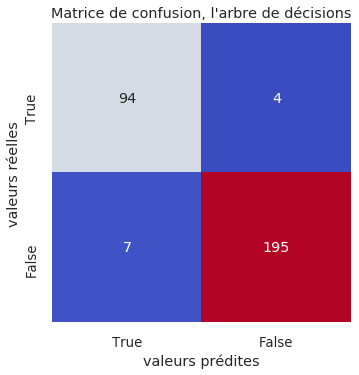

4. Rapport de classification, l'arbre de décisions :
              precision    recall  f1-score   support

       False       0.93      0.96      0.94        98
        True       0.98      0.97      0.97       202

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

5. Cross-validation résultats :
[0.97666667 0.96666667 0.98666667 0.98333333 0.96666667]


In [64]:
#évaluation du modèle
accuracy_arbre = "{:.2%}".format(round(metrics.accuracy_score(df_test_arbre['predicted'], ytest),4))
print(f"1. La précision de l'arbre de décisions : {accuracy_arbre}")

print('2. Billets mal identifiés :')
display(df_test_arbre[df_test_arbre['is_genuine'] != df_test_arbre['predicted']])

print("3. Matrice de confusion, l'arbre de décisions :")
conf_arbre = metrics.confusion_matrix(df_test_arbre['is_genuine'], df_test_arbre['predicted'])
sns.heatmap(conf_arbre, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title("Matrice de confusion, l'arbre de décisions")
plt.show()

print("4. Rapport de classification, l'arbre de décisions :")
print(metrics.classification_report(df_test_arbre['is_genuine'], df_test_arbre['predicted']))

print('5. Cross-validation résultats :')
scores_arbre = cross_val_score(arbre, data, target, cv=5)
score_arbre = np.mean(scores_arbre)
print(scores_arbre)

### **6. Naive Bayes - Machines vectorielles de soutien**<a class="anchor" id="section_3_8"></a>

In [65]:
#modélisation
gaus = GaussianNB()
gaus.fit(xtrain,ytrain)
#prédiction
ypred_gaus = gaus.predict(xtest)
df_test_gaus = df_test.copy()
df_test_gaus['predicted'] = ypred_gaus

1. La précision de la machine vectorielle de soutien : 99.33%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
1025    172.17       104.20        104.13        3.86       3.38  112.44   
1073    172.13       103.67        103.82        4.27       3.22  112.15   

      is_genuine  predicted  
1025       False       True  
1073       False       True

3. Matrice de confusion, la machine vectorielle de soutien :


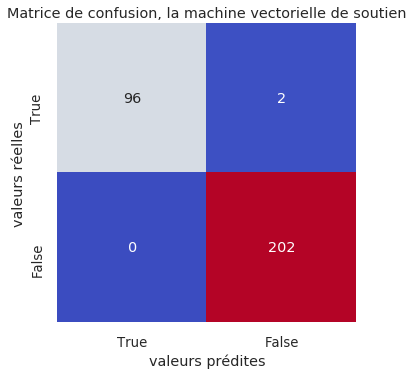

4. Rapport de classification, la machine vectorielle de soutien :
              precision    recall  f1-score   support

       False       1.00      0.98      0.99        98
        True       0.99      1.00      1.00       202

    accuracy                           0.99       300
   macro avg       1.00      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

5. Cross-validation résultats :
[0.99       0.98666667 0.99666667 0.99333333 0.99333333]


In [66]:
#évaluation du modèle
accuracy_gaus = "{:.2%}".format(round(metrics.accuracy_score(df_test_gaus['predicted'], ytest),4))
print(f"1. La précision de la machine vectorielle de soutien : {accuracy_gaus}")

print('2. Billets mal identifiés :')
display(df_test_gaus[df_test_gaus['is_genuine'] != df_test_gaus['predicted']])

print("3. Matrice de confusion, la machine vectorielle de soutien :")
conf_gaus = metrics.confusion_matrix(df_test_gaus['is_genuine'], df_test_gaus['predicted'])
sns.heatmap(conf_gaus, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title("Matrice de confusion, la machine vectorielle de soutien")
plt.show()

print("4. Rapport de classification, la machine vectorielle de soutien :")
print(metrics.classification_report(df_test_gaus['is_genuine'], df_test_gaus['predicted']))

print('5. Cross-validation résultats :')
scores_gaus = cross_val_score(gaus, data, target, cv=5)
score_gaus = np.mean(scores_gaus)
print(scores_gaus)

In [67]:
h = .15

/home/olga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



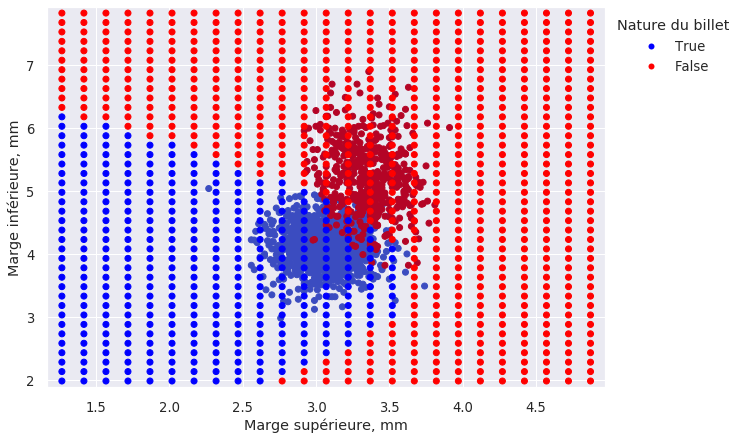

In [68]:
#on va répresenter les territoires de la classification pour les variables margin_up et margin_low
#on recherche les valeurs min/max de marge
x_m_min, x_m_max = data['margin_up'].min() - 1, data['margin_up'].max() + 1
y_m_min, y_m_max = data['margin_low'].min() - 1, data['margin_low'].max() + 1

x_m = np.arange(x_m_min, x_m_max, h)
y_m = np.arange(y_m_min, y_m_max, h)

#on obtient une grille de coordonnées pour les valeurs des points comprises entre x_min, x_max et y_min, y_max
xx_m, yy_m = np.meshgrid(x_m,y_m)
#on applatit les données du tableau
data_samples = list(zip(xx_m.ravel(), yy_m.ravel()))

#on réapprend
gaus.fit(xtrain[['margin_up', 'margin_low']],ytrain)
Z = gaus.predict(data_samples)

plt.figure(figsize=(10, 7))
#on trace les points d'entraînement 
plt.scatter(data['margin_up'], data['margin_low'], c=target, cmap='coolwarm_r')
colors = ['red', 'blue']
C = [colors[x] for x in Z]
plt.scatter(xx_m.ravel(), yy_m.ravel(), c=C)
plt.xlim(xx_m.min() - .1, xx_m.max() + .1)
plt.ylim(yy_m.min() - .1, yy_m.max() + .1)
plt.xlabel('Marge supérieure, mm')
plt.ylabel('Marge inférieure, mm')

#légende
line1 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[1], linewidth=0)
line2 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[0], linewidth=0)
plt.legend((line1, line2),(True, False), numpoints=1, title='Nature du billet', bbox_to_anchor =(1, 1))
plt.savefig('NB_1_billets.png', transparent=True, bbox_inches='tight')
plt.show()

/home/olga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



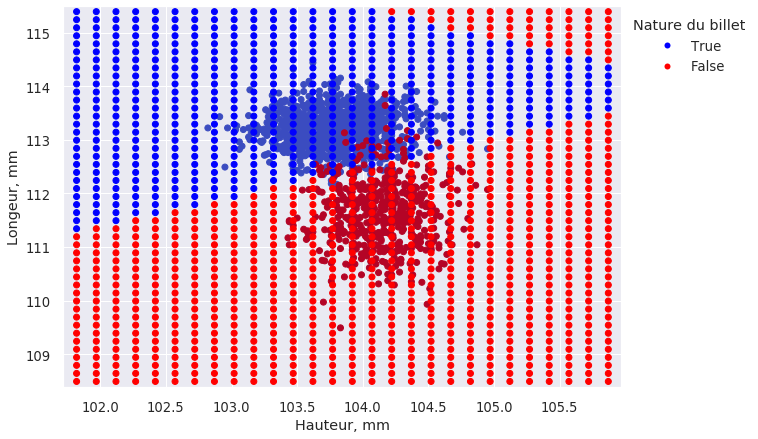

In [69]:
#on va répresenter les territoires de la classification pour les variables height_right et length
#on recherche les valeurs min/max de hauteur et de longeur
x_l_min, x_l_max = data['height_right'].min() - 1, data['height_right'].max() + 1
y_l_min, y_l_max = data['length'].min() - 1, data['length'].max() + 1

x_l = np.arange(x_l_min, x_l_max, h)
y_l = np.arange(y_l_min, y_l_max, h)

#on obtient une grille de coordonnées pour les valeurs des points comprises entre x_min, x_max et y_min, y_max
xx_l, yy_l = np.meshgrid(x_l,y_l)
#on applatit les données du tableau
data_samples = list(zip(xx_l.ravel(), yy_l.ravel()))

#on réapprend
gaus.fit(xtrain[['height_right', 'length']],ytrain)
Z = gaus.predict(data_samples)

plt.figure(figsize=(10, 7))
#on trace les points d'entraînement 
plt.scatter(data['height_right'], data['length'], c=target, cmap="coolwarm_r")
colors = ['red', 'blue']
C = [colors[x] for x in Z]
plt.scatter(xx_l.ravel(), yy_l.ravel(), c=C)
plt.xlim(xx_l.min() - .1, xx_l.max() + .1)
plt.ylim(yy_l.min() - .1, yy_l.max() + .1)
plt.xlabel('Hauteur, mm')
plt.ylabel('Longeur, mm')

#légende
line1 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor=colors[1], linewidth=0)
line2 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor=colors[0], linewidth=0)
plt.legend((line1, line2),(True, False), numpoints=1, title='Nature du billet', bbox_to_anchor =(1, 1))
plt.savefig('NB_2_billets.png', transparent=True, bbox_inches='tight')
plt.show()

### **7. Stochastic gradient descent**<a class="anchor" id="section_3_9"></a>

In [70]:
#modélisation
grad = SGDClassifier(loss="hinge")
grad.fit(xtrain, ytrain)
#prédiction
ypred_grad = grad.predict(xtest)
df_test_grad = df_test.copy()
df_test_grad['predicted'] = ypred_grad

1. La précision du stochastic gradient descent : 99.67%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
1025    172.17        104.2        104.13        3.86       3.38  112.44   

      is_genuine  predicted  
1025       False       True

3. Matrice de confusion, le stochastic gradient descent :


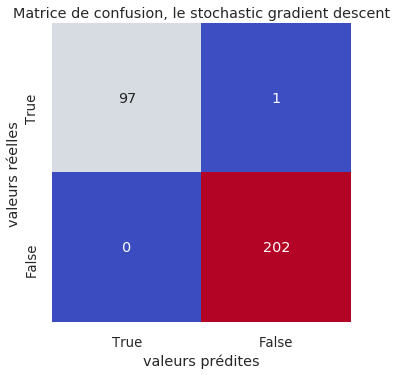

4. Rapport de classification, le stochastic gradient descent :
              precision    recall  f1-score   support

       False       1.00      0.99      0.99        98
        True       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300

5. Cross-validation résultats :
[0.98333333 0.66666667 0.66666667 0.33333333 0.97666667]


In [71]:
#évaluation du modèle
accuracy_grad = "{:.2%}".format(round(metrics.accuracy_score(df_test_grad['predicted'], ytest),4))
print(f"1. La précision du stochastic gradient descent : {accuracy_grad}")

print('2. Billets mal identifiés :')
display(df_test_grad[df_test_grad['is_genuine'] != df_test_grad['predicted']])

print("3. Matrice de confusion, le stochastic gradient descent :")
conf_grad = metrics.confusion_matrix(df_test_grad['is_genuine'], df_test_grad['predicted'])
sns.heatmap(conf_grad, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title("Matrice de confusion, le stochastic gradient descent")
plt.show()

print("4. Rapport de classification, le stochastic gradient descent :")
print(metrics.classification_report(df_test_grad['is_genuine'], df_test_grad['predicted'], zero_division=True))

print('5. Cross-validation résultats :')
scores_grad = cross_val_score(grad, data, target, cv=5)
score_grad = np.mean(scores_grad)
print(scores_grad)

### **8. Réseaux de neurones**<a class="anchor" id="section_3_10"></a>

In [72]:
#modélisation
neur = MLPClassifier(max_iter=500)
neur.fit(xtrain, ytrain)
#prédiction
ypred_neur = neur.predict(xtest)
df_test_neur = df_test.copy()
df_test_neur['predicted'] = ypred_neur

1. La précision des réseaux de neurones : 96.67%
2. Billets mal identifiés :


diagonal  height_left  height_right  margin_low  margin_up  length  \
877     171.95       103.62        103.91        4.91       2.90  113.17   
95      172.00       103.83        103.82        4.64       3.32  113.00   
1482    172.30       104.04        103.85        4.12       3.27  111.69   
687     172.02       104.23        104.26        4.92       2.89  113.49   
1378    171.41       104.20        103.73        4.31       3.32  111.74   
239     171.85       104.07        103.90        4.80       3.46  113.73   
1333    172.10       104.30        104.21        4.07       3.41  111.27   
1025    172.17       104.20        104.13        3.86       3.38  112.44   
1073    172.13       103.67        103.82        4.27       3.22  112.15   
791     171.82       103.67        103.80        4.60       3.49  113.32   

      is_genuine  predicted  
877         True      False  
95          True      False  
1482       False       True  
687         True      False  
1378       False       True  
239         True      False  
1333       False       True  
1025       False       True  
1073       False       True  
791         True      False

3. Matrice de confusion, les réseaux de neurones :


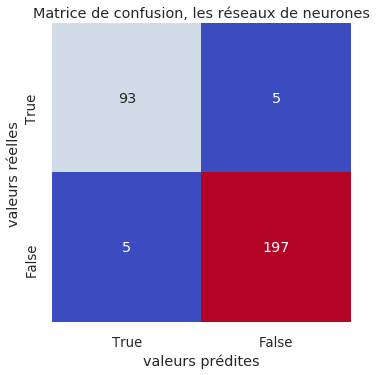

4. Rapport de classification, les réseaux de neurones :
              precision    recall  f1-score   support

       False       0.95      0.95      0.95        98
        True       0.98      0.98      0.98       202

    accuracy                           0.97       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.97      0.97      0.97       300

5. Cross-validation résultats :
[0.95666667 0.91666667 0.97       0.97       0.95333333]


In [73]:
#évaluation du modèle
accuracy_neur = "{:.2%}".format(round(metrics.accuracy_score(df_test_neur['predicted'], ytest),4))
print(f"1. La précision des réseaux de neurones : {accuracy_neur}")

print('2. Billets mal identifiés :')
display(df_test_neur[df_test_neur['is_genuine'] != df_test_neur['predicted']])

print("3. Matrice de confusion, les réseaux de neurones :")
conf_neur = metrics.confusion_matrix(df_test_neur['is_genuine'], df_test_neur['predicted'])
sns.heatmap(conf_neur, square=True, annot=True, cbar=False, xticklabels=list(ytest.unique()), yticklabels=list(ytest.unique()), cmap='coolwarm', fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.title("Matrice de confusion, les réseaux de neurones")
plt.show()

print("4. Rapport de classification, les réseaux de neurones :")
print(metrics.classification_report(df_test_neur['is_genuine'], df_test_neur['predicted']))

print('5. Cross-validation résultats :')
scores_neur = cross_val_score(neur, data, target, cv=5)
score_neur = np.mean(scores_neur)
print(scores_neur)

### **9. Choix du modèle**<a class="anchor" id="section_3_11"></a>

Maintenant on doit choisir le meilleur modèle en fonction du taux de précision. On prendra la moyenne de la validation croisée des modèles (sauf pour K-means, qui n'implique pas la séparation du jeu de données en training set et en testing set).

In [74]:
display(pd.DataFrame(data=[score_k, score_knn, score_log, score_arbre, score_gaus, score_grad, score_neur], 
             index=['K-means', 'K-NN', 'Régression logistique', 'Arbre de décisions', 'Naive Bayes, MVS', 'Stochastic gradient descent', 'Réseaux de neurones'],
             columns=['Cross-validation score, moyenne']).sort_values('Cross-validation score, moyenne', ascending=False).style.format({'Cross-validation score, moyenne': "{:.2%}"}))

On a deux modèles qui sont également efficaces : le Naive Bayes classifier et la régression logistique. On va utiliser ces deux méthodes afin de pouvoir comparer les résultats.

## **Mission 3. Analyse prédictive** <a class="anchor" id="chapter4"></a>

In [81]:
# on importe les billets à identifier
billets_to_predict = pd.read_csv('billets_production.csv')
billets_to_predict.set_index('id', inplace=True)
billets_to_predict

diagonal  height_left  height_right  margin_low  margin_up  length
id                                                                     
A_1    171.76       104.01        103.54        5.21       3.30  111.42
A_2    171.87       104.17        104.13        6.00       3.31  112.09
A_3    172.00       104.58        104.29        4.99       3.39  111.57
A_4    172.49       104.55        104.34        4.44       3.03  113.20
A_5    171.65       103.63        103.56        3.77       3.16  113.33

In [82]:
#modélisation
gaus = GaussianNB()
gaus.fit(data,target)

#prédiction
billets_pred_gaus = gaus.predict(billets_to_predict)
df_test_gaus = billets_to_predict.copy()
df_test_gaus['predicted'] = billets_pred_gaus
df_test_gaus

diagonal  height_left  height_right  margin_low  margin_up  length  \
id                                                                        
A_1    171.76       104.01        103.54        5.21       3.30  111.42   
A_2    171.87       104.17        104.13        6.00       3.31  112.09   
A_3    172.00       104.58        104.29        4.99       3.39  111.57   
A_4    172.49       104.55        104.34        4.44       3.03  113.20   
A_5    171.65       103.63        103.56        3.77       3.16  113.33   

     predicted  
id              
A_1      False  
A_2      False  
A_3      False  
A_4       True  
A_5       True

In [83]:
#modélisation
reg_log_sklearn = LogisticRegression(max_iter=200)
reg_log_sklearn.fit(data, target)

#prédiction
billets_pred_log = reg_log_sklearn.predict(billets_to_predict)
df_test_log = billets_to_predict.copy()
df_test_log['predicted'] = billets_pred_log
df_test_log

diagonal  height_left  height_right  margin_low  margin_up  length  \
id                                                                        
A_1    171.76       104.01        103.54        5.21       3.30  111.42   
A_2    171.87       104.17        104.13        6.00       3.31  112.09   
A_3    172.00       104.58        104.29        4.99       3.39  111.57   
A_4    172.49       104.55        104.34        4.44       3.03  113.20   
A_5    171.65       103.63        103.56        3.77       3.16  113.33   

     predicted  
id              
A_1      False  
A_2      False  
A_3      False  
A_4       True  
A_5       True

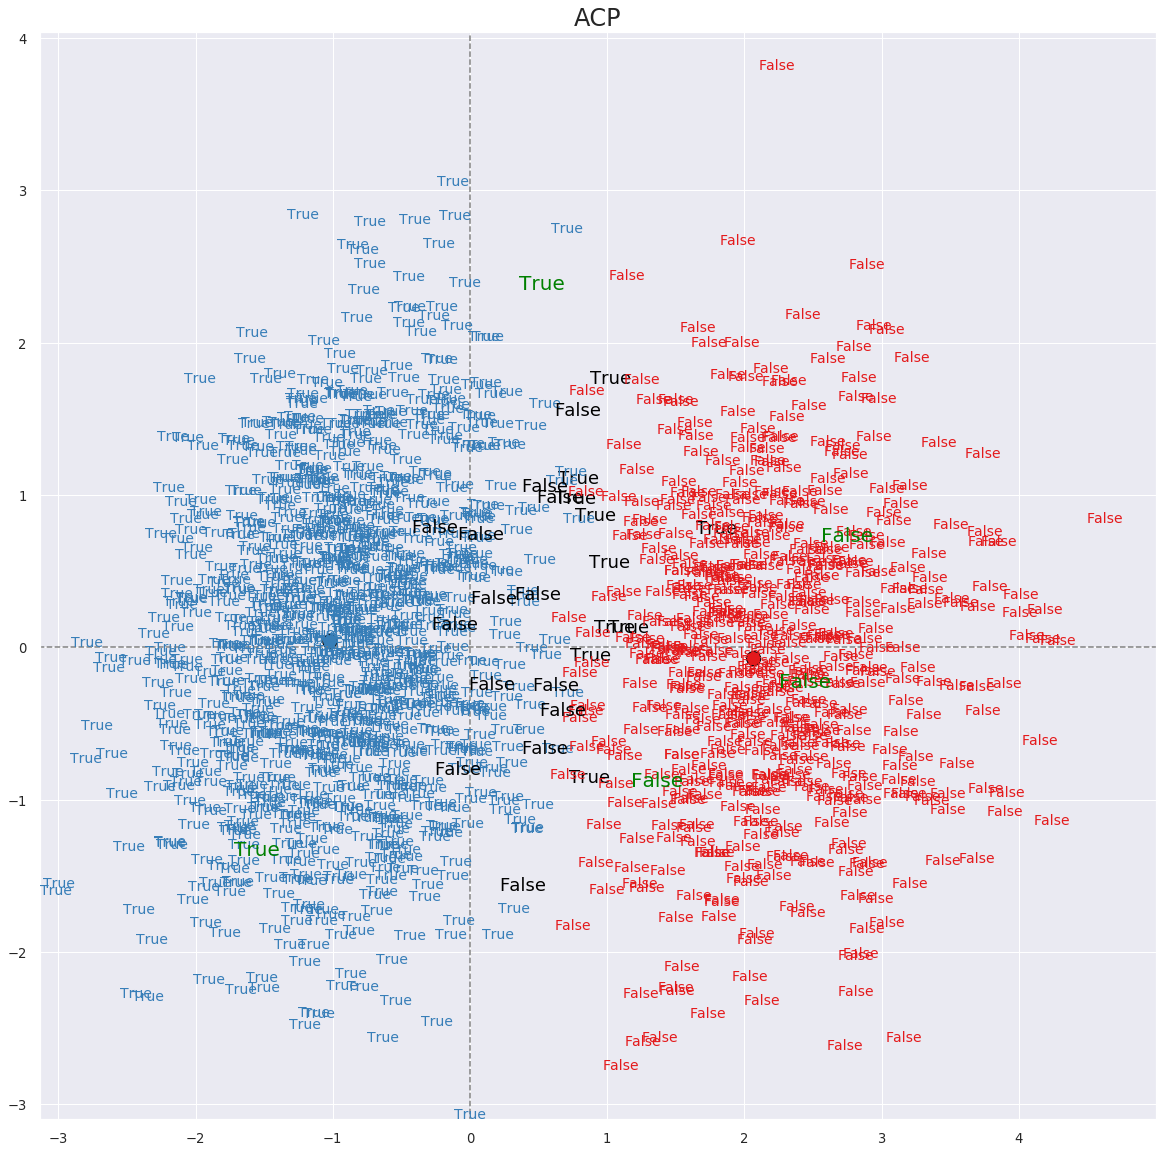

In [84]:
pred_scaled = std_scale.transform(df_test_log[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']])
pred_projected = pca.transform(pred_scaled)
fig = plt.figure(figsize=(20,20))

colors = np.array([(0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
                  (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)])

for i in range(X.shape[0]):
    if (kmeans.labels_[i] == 0 and y[i]) or (kmeans.labels_[i] == 1 and not y[i]):
    #si le billet a été bien détecté on le projete en rouge ou en blue (cela dépend du cluster)    
        plt.text(X_projected[i, 0], X_projected[i, 1], str(y[i]), color=colors[kmeans.labels_[i]], fontsize=14)
    else:
    #si le billet a été mal détecté on le projete en noir avec son nom réel 
        plt.text(X_projected[i, 0], X_projected[i, 1], str(y[i]), color='black', fontsize=18)
plt.xlim([np.min(X_projected[:, 0]), np.max(X_projected[:, 0])+0.5])
plt.ylim([np.min(X_projected[:, 1]), np.max(X_projected[:, 1])+0.25])
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')
#centroïdes
plt.scatter(centroids_projected[:,0] , centroids_projected[:,1] , s=200, c=colors, cmap='Set1', marker='o', edgecolors='black')
#prédictions
for i in range(pred_scaled.shape[0]):
    plt.text(pred_projected[i, 0], pred_projected[i, 1], str(df_test_log['predicted'][i]), color='green', fontsize=20)
plt.title('ACP', fontsize=24)
plt.show()